In [2]:
import numpy as np
import minimg as mg
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from math import factorial
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def XYZ_to_RGB(XYZ):
    XYZ_to_RGB = np.array([[0.41847, -0.15866, -0.082835],
                            [-0.091169, 0.25243, 0.015708],
                            [0.000920, -0.002549, 0.17860]])
    return np.dot(XYZ_to_RGB, XYZ)

def C_sRGB(C_lin):
    if C_lin <= 0.0031308:
        return 12.92 * C_lin
    else: return 1.055 * C_lin ** (1 / 2.4) - 0.055

def RGB_to_sRGB(RGB):
    return np.array([C_sRGB(RGB[0]), C_sRGB(RGB[1]), C_sRGB(RGB[2])])

def XYZ_to_LMS(XYZ):
    XYZ_to_LMS = np.array([[0.38971, 0.68898, -0.07868],
                          [-0.22981, 1.18340, 0.04641],
                          [0.0, 0.0, 1.0]])
    return np.dot(XYZ_to_LMS, XYZ)

In [4]:
# взято из https://books.google.ru/books?id=U8jeh1uhSHgC&pg=PA167&lpg=PA167&dq=cieluv+un+vn&source=bl&ots=SV9nETcTgT&sig=ACfU3U1KpRKswHA1dO8FsjqbNdO8PxoaPg&hl=ru&sa=X&ved=2ahUKEwjI447Jo7DlAhX18KYKHSXQA5gQ6AEwAnoECAgQAQ#v=onepage&q=cieluv%20un%20vn&f=false
XYZ_WHITE_POINT_D65_X = 95.04#0.3127
XYZ_WHITE_POINT_D65_Y = 100.0#0.329
XYZ_WHITE_POINT_D65_Z = 108.89
CIELUV_D65_u_stick_n = 0.1978
CIELUV_D65_v_stick_n = 0.4683

WHITEPOINTRGB = [2754.907432227824, 2905.2600332985335, 3118.0681991097817]


In [97]:
def XYZ_to_CIELUV(c, whitePoint):
    L_star, u_star, v_star = 0, 0, 0
    X, Y, Z = c[0], c[1], c[2]
    X_n, Y_n, Z_n = whitePoint[0], whitePoint[1], whitePoint[2]
    
    u_stick_n = 4 * X_n / (X_n + 15 * Y_n + 3 * Z_n)
    v_stick_n = 9 * X_n / (X_n + 15 * Y_n + 3 * Z_n)
    
    if Y / Y_n <= (6 / 29) ** 3:
        L_star = (29 / 3) ** 3 * Y / Y_n
    else:
        L_star = 116 * (Y / Y_n) ** (1 / 3) - 16
    
    u_stick = 4 * X / (X + 15 * Y + 3 * Z)
    v_stick = 9 * Y / (X + 15 * Y + 3 * Z)
    
    u_star = 13 * L_star * (u_stick - u_stick_n)
    v_star = 13 * L_star * (v_stick - v_stick_n)
    
    return np.array([L_star, u_star, v_star])

def CIELUV_DeltaE_from_XYZ(XYZ1, XYZ2, whitePoint):
    return np.linalg.norm(XYZ_to_CIELUV(XYZ1, whitePoint) - XYZ_to_CIELUV(XYZ2, whitePoint))

In [98]:
patch_spectras = ['Dark Skin.reflect', 'Light Skin.reflect', 'Blue Sky.reflect',
                 'Foilage.reflect', 'Blue Flower.reflect', 'Bluish Green.reflect',
                 'Orange.reflect', 'Purplish Blue.reflect', 'Moderate Red.reflect',
                 'Purple.reflect', 'Yellow Green.reflect', 'Orange Yellow.reflect',
                 'Blue.reflect', 'Green.reflect', 'Red.reflect',
                 'Yellow.reflect', 'Magenta.reflect', 'Cyan.reflect',
                 'White.reflect', 'Neutral-8.reflect', 'Neutral-6.5.reflect',
                 'Neutral-5.reflect', 'Neutral-3.5.reflect', 'Black.reflect']

In [99]:
x = np.linspace(380, 780, 101)

#D65 source
src = np.loadtxt("./d65.illum")
x_src = np.linspace(300, 830, 531)
src = np.interp(x, x_src, src)
D65 = np.diag(src)

#XYZ spectral sensitivities
f = open('camera.kinect1.json', 'r')
xyz_dict = json.load(f)
XYZ_R = np.array(xyz_dict['sensitivities']['red'])[:, 1]
XYZ_G = np.array(xyz_dict['sensitivities']['green'])[:, 1]
XYZ_B = np.array(xyz_dict['sensitivities']['blue'])[:, 1]
x_XYZ = np.linspace(365, 830, 94) 
sens_XYZ_R = np.interp(x, x_XYZ, XYZ_R)
sens_XYZ_G = np.interp(x, x_XYZ, XYZ_G)
sens_XYZ_B = np.interp(x, x_XYZ, XYZ_B)

#RGB camera sensitivities
cam_R, cam_G, cam_B = np.loadtxt("cam_R.spect"), np.loadtxt("cam_G.spect"), np.loadtxt("cam_B.spect")
x_RGB = np.linspace(380, 784, 101)
sens_RGB_R = np.interp(x, x_RGB, cam_R)
sens_RGB_G = np.interp(x, x_RGB, cam_G)
sens_RGB_B = np.interp(x, x_RGB, cam_B)


colorsXYZ = []
for patch in patch_spectras:
    refl = np.loadtxt("./patches/" + patch)
    X = np.dot(np.dot(sens_XYZ_R.T, D65), refl)
    Y = np.dot(np.dot(sens_XYZ_G.T, D65), refl)
    Z = np.dot(np.dot(sens_XYZ_B.T, D65), refl)
    c = np.array([X, Y, Z])
    colorsXYZ.append(c)
colorsXYZ = np.array(colorsXYZ)

colorsRGB = []
for patch in patch_spectras:
    refl = np.loadtxt("./patches/" + patch)
    R = np.dot(np.dot(sens_RGB_R.T, D65), refl)
    G = np.dot(np.dot(sens_RGB_G.T, D65), refl)
    B = np.dot(np.dot(sens_RGB_B.T, D65), refl)
    c = np.array([R, G, B])
    colorsRGB.append(c)
colorsRGB = np.array(colorsRGB)

In [100]:
X_WHITE = np.dot(sens_XYZ_R.T, src)
Y_WHITE = np.dot(sens_XYZ_G.T, src)
Z_WHITE = np.dot(sens_XYZ_B.T, src)
print("White point: ", X_WHITE, Y_WHITE, Z_WHITE)
WHITE_POINT_XYZ_D65 = [X_WHITE, Y_WHITE, Z_WHITE]

White point:  2754.907432227824 2905.2600332985335 3118.0681991097817


In [101]:
TERMS_P1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
TERMS_P2 = np.concatenate((TERMS_P1, np.array([[1 / 2, 1 / 2, 0], 
                                             [1 / 2, 0, 1 / 2], 
                                   [0, 1 / 2, 1 / 2]])))
TERMS_P3 = np.concatenate((TERMS_P2, np.array([ [1 / 3, 2 / 3, 0], 
                                             [0, 1 / 3, 2 / 3], 
                                             [1 / 3, 0, 2 / 3], 
                                             [2 / 3, 1 / 3, 0], 
                                             [0, 2 / 3, 1 / 3], 
                                             [2 / 3, 0, 1 / 3], 
                                             [1 / 3, 1 / 3, 1 / 3] ])))
TERMS_P4 = np.concatenate((TERMS_P3, np.array([ [3 / 4, 1 / 4, 0],
                                            [3 / 4, 0, 1 / 4],
                                            [1 / 4, 3 / 4, 0],
                                            [0, 3 / 4, 1 / 4],
                                            [1 / 4, 0, 3 / 4],
                                            [0, 1 / 4, 3 / 4],
                                            [2 / 4, 1 / 4, 1 / 4],
                                            [1 / 4, 2 / 4, 1 / 4],
                                            [1 / 4, 1 / 4, 2 / 4] ])))
POLYTERMS = np.array([TERMS_P1, TERMS_P2, TERMS_P3, TERMS_P4])

In [102]:
#! Input:
#!     X - array 3xN
#!     power - power of polynoms
#! Output:
#!     PxN array, where P - amount of root-polynomial terms
def get_rp_features(X, power):
    terms = POLYTERMS[0]
    if power == 2: terms = POLYTERMS[1]
    if power == 3: terms = POLYTERMS[2]
    if power == 4: terms = POLYTERMS[3]
    features = []
    for term in terms:
        #print("term: ", term)
        a = np.power(X.T, term)
        #print("a: ", a)
        b = np.prod(a, axis = 1)
        #print("b: ", b)
        features.append(b)
    return np.array(features)

def q_rp_features(power):
    if power == 2: return 6
    if power == 3: return 13
    if power == 4: return 22
    else: return 3

In [103]:
power = 3

In [104]:
R = colorsRGB.T
R = get_rp_features(R, power)
Q = colorsXYZ.T
print("R shape: ", R.shape)
print("Q shape: ", Q.shape)

y_r = Q[0]
y_g = Q[1]
y_b = Q[2]
X = R.T
print(X.shape)

R shape:  (13, 24)
Q shape:  (3, 24)
(24, 13)


In [105]:
err = 0
for i in range(R.shape[1]):
    Q_train = np.concatenate((Q[:, :i], Q[:, (i+1):]), axis=1)
    R_train = np.concatenate((R[:, :i], R[:, (i+1):]), axis=1)
    Q_test = Q[:, i]
    R_test = R[:, i]
    A = np.dot(np.dot(Q_train, R_train.T), np.linalg.inv(np.dot(R_train, R_train.T)))
    print("[", i, "]", "========")
    train_err = 0
    for j in range(Q_train.shape[1]):
        deltaE = CIELUV_DeltaE_from_XYZ(np.dot(A, R_train[:, j]), Q_train[:, j], WHITE_POINT_XYZ_D65)
        print(deltaE, np.dot(A, R_train[:, j]), Q_train[:, j])
        train_err += deltaE
    print("Error on train:", train_err / 23)
    deltaE = CIELUV_DeltaE_from_XYZ(np.dot(A, R_test), Q_test, WHITE_POINT_XYZ_D65)
    print("Error on test:", deltaE)
    err += deltaE
    
print("!", err / 24)
    

[ 0 ] ========
0.5191200418061283 [1004.31783304  951.20621272  711.43596819] [1001.45874109  945.74111229  709.30746042]
1.6897653972154387 [484.56883409 538.72822948 946.16142706] [489.78028242 536.60625771 939.30494455]
0.8942075679788288 [288.59803727 352.42081877 203.58221896] [283.36297245 344.62853133 193.60818096]
0.8105523213970038 [ 680.25376681  670.70484949 1194.19048046] [ 676.89070139  669.4389975  1200.66611555]
0.11266794245950115 [ 873.80008608 1181.44082883 1193.54506845] [ 872.95120847 1180.29327278 1194.0041255 ]
1.29334037367862 [1003.65118486  795.04670342  207.85618832] [999.27634865 795.87049562 211.63347314]
0.5530125757561457 [ 383.27605315  367.97847127 1030.66547761] [ 380.75745584  365.4015173  1032.75991716]
1.0785420749481953 [755.26012621 542.50331282 423.5505088 ] [759.05026763 542.49706991 420.69895798]
1.7680971654741306 [245.56102095 200.78372827 444.55732031] [250.61123706 203.02932777 438.36746551]
0.8383935068466041 [ 953.60649986 1168.89289744  3

1.0212590141623468 [ 987.55922847 1037.56761011 1121.87648483] [ 985.88558922 1037.53027828 1105.80798251]
1.2196482285489676 [555.54926475 583.83979308 650.68870299] [554.08686204 583.38131725 636.31506322]
1.065004733355892 [273.3333584  286.7265042  316.51336295] [272.32453864 286.37371819 307.91985194]
0.6419486704902837 [84.25040191 87.94104364 99.38929315] [83.89851034 87.746245   96.32400599]
Error on train: 0.7255711584644478
Error on test: 3.039605408537276
[ 9 ] ========
1.0350241232687682 [317.70254975 289.71301714 210.28894621] [318.9394091  289.27117144 205.44411305]
0.5871091767831511 [1002.8385067   950.25181122  712.25067527] [1001.45874109  945.74111229  709.30746042]
1.6575670637642665 [484.79799488 538.87046467 946.014755  ] [489.78028242 536.60625771 939.30494455]
0.6797439875812756 [289.58449731 352.94994037 202.67599794] [283.36297245 344.62853133 193.60818096]
0.33218382825924 [ 677.73131889  669.5248725  1197.08448645] [ 676.89070139  669.4389975  1200.66611555]

2.040447055411386 [246.12280657 201.30357419 448.00705385] [250.61123706 203.02932777 438.36746551]
0.836007575890481 [ 953.79351245 1169.03536374  323.66840181] [ 952.76198636 1173.21388798  325.80137321]
0.43198933420740054 [1244.9123877  1123.56017648  248.91852744] [1249.3971902  1126.04704323  248.16670635]
0.30882139456533403 [226.23033013 195.16759034 782.84406105] [227.74324156 196.62725482 782.40297931]
0.999203187181034 [446.23082119 657.52038849 294.77057519] [448.75210787 655.6286731  293.03455874]
0.643184596930334 [528.7197264  337.43936429 181.40510094] [529.71842719 336.53734171 181.61794445]
0.2737705996040471 [1551.96826234 1600.6553755   286.66133512] [1551.30984448 1598.06734834  285.99220386]
0.7554185130489429 [772.75514399 546.9448942  847.27245146] [770.33560082 547.54950919 849.95598537]
0.5031318142046637 [ 432.8839965   607.49142862 1082.61030566] [ 431.91096526  609.18798714 1082.80309541]
0.2331647673462113 [1577.3835074  1662.50960188 1769.48357147] [1579.

In [14]:
a = XYZ_to_CIELUV(np.array([274.07249923, 281.11144134, 308.43766985]), WHITE_POINT_XYZ_D65)
a

array([37.25444054,  2.19548136, 10.60467849])

In [15]:
b = XYZ_to_CIELUV(np.array([272.32453864, 286.37371819, 307.91985194]), WHITE_POINT_XYZ_D65)
b

array([37.58468789,  0.23079971, 11.7690208 ])

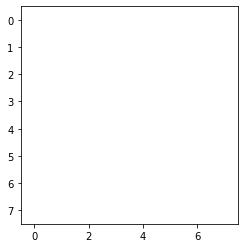

In [16]:
a = np.zeros((8, 8, 3))
a[:, :] = WHITE_POINT_XYZ_D65
plt.imshow(a / np.array(a))

In [38]:
a = np.array([[1, 2, 3, 1],
    [4, 5, 6, 1],
    [7, 8, 9, 1]])
a

array([[1, 2, 3, 1],
       [4, 5, 6, 1],
       [7, 8, 9, 1]])

In [42]:
for i in range(a.shape[1]):
    print(a[:, i])
    print(np.concatenate((a[:, :i], a[:, (i+1):]), axis=1), '\n')

[1 4 7]
[[2 3 1]
 [5 6 1]
 [8 9 1]] 

[2 5 8]
[[1 3 1]
 [4 6 1]
 [7 9 1]] 

[3 6 9]
[[1 2 1]
 [4 5 1]
 [7 8 1]] 

[1 1 1]
[[1 2 3]
 [4 5 6]
 [7 8 9]] 



In [45]:
# LOO = LeaveOneOut()
# err = 0
# for train_index, test_index in LOO.split(X):
#     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_r_train, y_r_test = y_r[train_index], y_r[test_index]
#     y_g_train, y_g_test = y_g[train_index], y_g[test_index]
#     y_b_train, y_b_test = y_b[train_index], y_b[test_index]
#     clsfR = LinearRegression()
#     clsfG = LinearRegression()
#     clsfB = LinearRegression()
#     clsfR.fit(X_train, y_r_train)
#     clsfG.fit(X_train, y_g_train)
#     clsfB.fit(X_train, y_b_train)
    
#     prR = clsfR.predict(X_test)
#     prG = clsfG.predict(X_test)
#     prB = clsfB.predict(X_test)
    
#     A = np.zeros((3, q_rp_features(power)))
#     A[0] = clsfR.coef_
#     A[1] = clsfG.coef_
#     A[2] = clsfB.coef_
    
#     #print(A)
    
#     pred2 = np.array([prR[0], prG[0], prB[0]])
#     gt = np.array([y_r_test[0], y_g_test[0], y_b_test[0],])

    
    
#     print("=========")
#     print("gt:", gt)
#     print("pred: ", pred)
#     print("A*raw:", np.dot(A, X_test[0]))
#     pred = np.dot(A, X_test[0])
#     #ang = 180 * np.arccos(np.round(np.dot(pred, gt) / np.linalg.norm(pred) / np.linalg.norm(gt), 8)) / np.pi
#     DeltaE = CIELUV_DeltaE_from_XYZ(pred, gt, WHITE_POINT_XYZ_D65)
#     print("error without intercept: ",DeltaE)
#     print("error with intecept: ", CIELUV_DeltaE_from_XYZ(pred2, gt, WHITE_POINT_XYZ_D65))
#     err += DeltaE
# print("!mean: ", err / 24)

In [87]:
R = np.array([[1, 2, 2, 2],
             [1, 2, 3, 1],
             [4, 4, 4, 6]])
get_rp_features(R, 3)

array([[1.        , 2.        , 2.        , 2.        ],
       [1.        , 2.        , 3.        , 1.        ],
       [4.        , 4.        , 4.        , 6.        ],
       [1.        , 2.        , 2.44948974, 1.41421356],
       [2.        , 2.82842712, 2.82842712, 3.46410162],
       [2.        , 2.82842712, 3.46410162, 2.44948974],
       [1.        , 2.        , 2.62074139, 1.25992105],
       [2.5198421 , 3.1748021 , 3.63424119, 3.30192725],
       [2.5198421 , 3.1748021 , 3.1748021 , 4.16016765],
       [1.        , 2.        , 2.28942849, 1.58740105],
       [1.58740105, 2.5198421 , 3.30192725, 1.81712059],
       [1.58740105, 2.5198421 , 2.5198421 , 2.88449914],
       [1.58740105, 2.5198421 , 2.88449914, 2.28942849]])